# Data422 Group Project

# The A+ team
Jacob Reid Mr. T (JRE141 - 47369324) <br/> 
Rick (Mengyao Liu) John "Hannibal" Smith (MLI181 - 43416446) <br/>
Katie (Jinghang Liu) Amy Amanda "Triple A" Allen (JLI3971 - 11854129) <br/>

In [1]:
begin
	using Pkg
    PkgList = ["CSV", "DataFrames", "Ipopt", "JuMP", "Plots", "PlutoUI", "Queryverse", "XLSX", "StatsBase", "Query", "VegaLite", "RData", "Lathe", "GLM", "StatsPlots", "MLBase", "RDatasets", "Clustering", "CodecBzip2", "RCall"]
    for p in PkgList
        if Base.find_package(p) == nothing
            Pkg.add(p)
        end
	end
end


In [2]:
using CSV, VegaLite, DataFrames, RData, Query, Queryverse, CodecBzip2, Plots

In [3]:
# loads the dataframe (loads as a dictionary)
weekly_energy_prices = load("./Datasets/price.rda",convertdataframes=true)
weekly_energy_prices = weekly_energy_prices["price"]
# rename price_details Fuel to Fuel Type
#df = DataFrame(A = 1:4, B = ["M", "F", "F", "M"], C = [32, 45, 28, 67])
#df_new = rename(df, :A => :ID, :B => :Gender, :C => :Age)

,Week,Fuel,Value,Unit
,Date…,String,Float64,String
1,2004-04-23,Diesel price,67.5,nzd
2,2004-04-23,Regular petrol price,114.5,nzd
3,2004-04-23,Premium petrol 95R price,117.9,nzd
4,2004-04-30,Diesel price,66.0,nzd
5,2004-04-30,Regular petrol price,113.0,nzd
6,2004-04-30,Premium petrol 95R price,120.9,nzd
7,2004-05-07,Diesel price,70.4,nzd
8,2004-05-07,Regular petrol price,117.3,nzd
9,2004-05-07,Premium petrol 95R price,126.9,nzd


In [4]:
weekly_energy_prices = rename(weekly_energy_prices, :Fuel => :"Fuel_Type")

,Week,Fuel_Type,Value,Unit
,Date…,String,Float64,String
1,2004-04-23,Diesel price,67.5,nzd
2,2004-04-23,Regular petrol price,114.5,nzd
3,2004-04-23,Premium petrol 95R price,117.9,nzd
4,2004-04-30,Diesel price,66.0,nzd
5,2004-04-30,Regular petrol price,113.0,nzd
6,2004-04-30,Premium petrol 95R price,120.9,nzd
7,2004-05-07,Diesel price,70.4,nzd
8,2004-05-07,Regular petrol price,117.3,nzd
9,2004-05-07,Premium petrol 95R price,126.9,nzd


In [5]:
weekly_energy_prices |> describe


,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Any,Any,Int64
1,Week,,2004-04-23,2013-11-29,2023-07-07,0
2,Fuel_Type,,Diesel price,,Regular petrol price,0
3,Value,170.986,66.0,174.878,316.203,0
4,Unit,,nzd,,nzd,0


In [6]:
# Resolved a selector issue for years
function compile_year_data(year, dataset)
    df_year_data = DataFrame()
    # compile year data from the fields given
    for data in eachrow(dataset)
        #ate_to_string = string(data.Week)
        #year = split(string(data.Week),"-")[1]
        year_data = split(string(data.Week),"-")[1]
        if occursin(year, year_data)
            push!(df_year_data,data)
        end
    end
    return(df_year_data)
end

compile_year_data (generic function with 1 method)

In [7]:
year = "2008"
df_year_data = compile_year_data(year, weekly_energy_prices)
df_year_data |> describe

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,Week,,2008-01-04,,2008-12-26,0,Date
2,Fuel_Type,,Diesel price,,Regular petrol price,0,String
3,Value,170.783,107.3,174.65,221.55,0,Float64
4,Unit,,nzd,,nzd,0,String


In [8]:
df_year_data

,Week,Fuel_Type,Value,Unit
,Date…,String,Float64,String
1,2008-01-04,Diesel price,123.4,nzd
2,2008-01-04,Regular petrol price,169.7,nzd
3,2008-01-04,Premium petrol 95R price,178.985,nzd
4,2008-01-11,Diesel price,128.4,nzd
5,2008-01-11,Regular petrol price,174.0,nzd
6,2008-01-11,Premium petrol 95R price,178.985,nzd
7,2008-01-18,Diesel price,126.3,nzd
8,2008-01-18,Regular petrol price,171.8,nzd
9,2008-01-18,Premium petrol 95R price,173.984,nzd


In [9]:
# now we would just need a selector for this

In [10]:
# Turn the iterator into a function!
function remove_col_text(column_name,text_string,target_df, replacement_text)
    for col in column_name
        for (i, text) in enumerate(target_df[!, col])
            target_df[i, col] = replace(uppercasefirst(lowercase(text)), text_string => replacement_text)
        end
    end
end

remove_col_text (generic function with 1 method)

In [11]:
# test to see how to add fields to a dataframe!
# We use :product to specify the "product" column, and Symbol("Cost in Dollars") to create a symbol for the "Cost in Dollars" column.
# We use the => operator to assign values to these columns.

# This code should create a new DataFrame df_test with the desired columns and values without encountering the "invalid keyword argument name" error.
df_fuelprice_dollars = DataFrame(
    Symbol("Week") => df_year_data.Week,
    #Symbol("Fuel Type") => df_year_data."Fuel price measure",
    Symbol("Fuel_Type") => df_year_data."Fuel_Type",
    Symbol("Cost in Dollars") => df_year_data.Value / 100
)

# Define the text to remove

# We define an example DataFrame df with two columns: "Fuel price measure" and "Value Label."

# We specify the text_to_find (string to be replaced) and the replacement_text (string to replace with).

# We create a loop to iterate through the specified columns (columns_to_search) and replace the text using the replace function for each row in those columns.

# After running this code, the specified text ("excluding taxes" in this example) will be replaced with the desired replacement text ("without taxes" in this example) in the specified columns of the DataFrame.
# text_to_find = " excluding taxes"
# replacement_text = ""
# columns_to_search = [:"Fuel"]
# text_to_find = ["excluding taxes","price"]

# for text in text_to_find
#     remove_col_text(columns_to_search, text, df_fuelprice_dollars, replacement_text)
# end

# Remove the text from the specified columns


,Week,Fuel_Type,Cost in Dollars
,Date…,String,Float64
1,2008-01-04,Diesel price,1.234
2,2008-01-04,Regular petrol price,1.697
3,2008-01-04,Premium petrol 95R price,1.78985
4,2008-01-11,Diesel price,1.284
5,2008-01-11,Regular petrol price,1.74
6,2008-01-11,Premium petrol 95R price,1.78985
7,2008-01-18,Diesel price,1.263
8,2008-01-18,Regular petrol price,1.718
9,2008-01-18,Premium petrol 95R price,1.73984


# TODO Plot
This could be a function so it is easier to plot but not sure how it will work may have to return
the data back so it gets displayed.

For a later consideration

In [12]:
function plot_data(df, lookupvalue, lookupcolumn, columntoplot, figname)
    """
    Function to plot the data, takes in values as needed to model the graph.
    Gets the dataset, needs a lookup value and the column to find,
    plots the data matching in the lookup column.

    Plot the data example, using one field.
    l_value = "Premium petrol 95R" <- what data we are looking for
    l_column = "Fuel_Type" <- the column the data is in
    c_toplot = "Cost in Dollars" <- the column to graph
    figname = "lineplot_prem_petrol" <- name of the figure when saved
    df_fuelprice_dollars <- target dataset to look for
    plot_data(df_fuelprice_dollars, l_value, l_column, c_toplot, figname)
    """
    
    # Create an empty array to store the data to be plotted
    plot_data = Float64[]  # Assuming the data is numeric
    
    for row in eachrow(df)
        if occursin(lookupvalue, string(row[lookupcolumn]))  # Convert the column value to a string for comparison
            push!(plot_data, row[columntoplot])
        end
    end
    
    # Plot the extracted data
    plot_data = plot(plot_data, legend=false, xlabel=lookupcolumn, ylabel=columntoplot)
    savefig("JuliaPlots/$figname.png")
    plot_data
end

plot_data (generic function with 1 method)

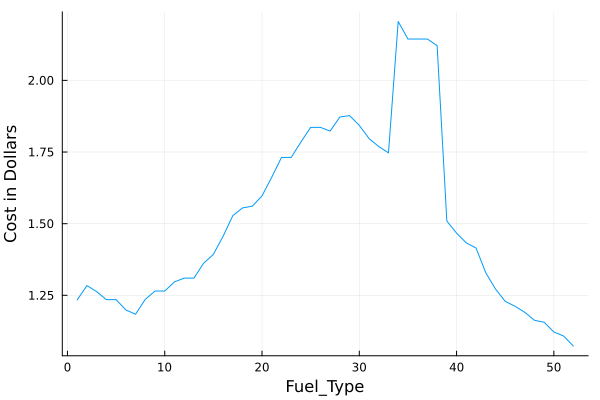

In [13]:
l_value = "Diesel" 
l_column = "Fuel_Type" 
c_toplot = "Cost in Dollars" 
figname = "lineplot_diesel"
plot_data(df_fuelprice_dollars, l_value, l_column, c_toplot, figname)

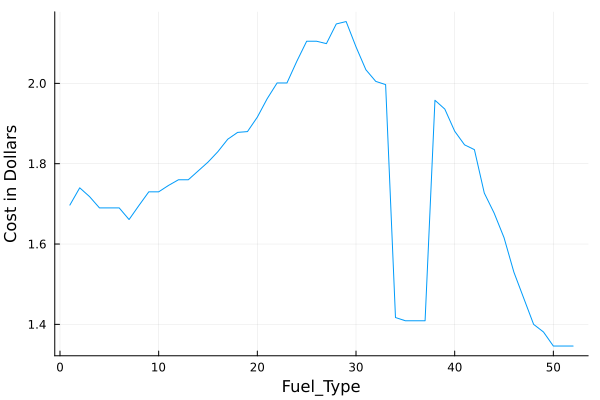

In [14]:
l_value = "Regular petrol" 
l_column = "Fuel_Type" 
c_toplot = "Cost in Dollars" 
figname = "lineplot_reg_petrol"
plot_data(df_fuelprice_dollars, l_value, l_column, c_toplot, figname)

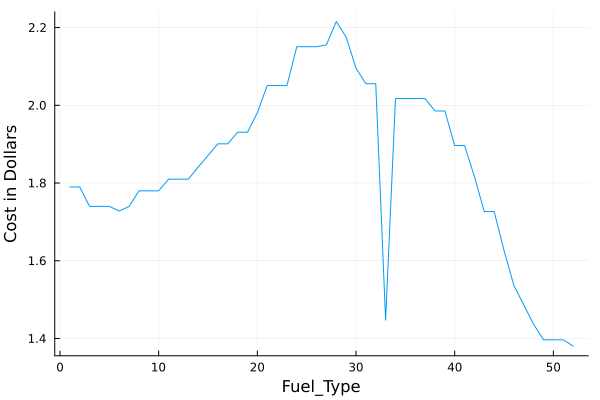

In [15]:
l_value = "Premium petrol 95R" 
l_column = "Fuel_Type" 
c_toplot = "Cost in Dollars" 
figname = "lineplot_prem_petrol"
plot_data(df_fuelprice_dollars, l_value, l_column, c_toplot, figname)

# linear regression test
from https://www.machinelearningplus.com/linear-regression-in-julia/

In [16]:
 # Load the installed packages
using Lathe, GLM, Statistics, StatsPlots, MLBase

# Enable printing of 1000 columns
ENV["COLUMNS"] = 1000

1000

In [17]:
df = df_fuelprice_dollars
first(df,5)


,Week,Fuel_Type,Cost in Dollars
,Date…,String,Float64
1,2008-01-04,Diesel price,1.234
2,2008-01-04,Regular petrol price,1.697
3,2008-01-04,Premium petrol 95R price,1.78985
4,2008-01-11,Diesel price,1.284
5,2008-01-11,Regular petrol price,1.74


In [18]:
println(size(df))
#> (111, 3)
println(names(df))

(156, 3)
["Week", "Fuel_Type", "Cost in Dollars"]


In [19]:
# Fix column names by replacing ' ', '-', '/' with '_'
colnames = Symbol[]
for i in string.(names(df))
    push!(colnames,Symbol(replace(replace(replace(strip(i)," " => "_"),"-" => "_"), "/" => "_")))
end

rename!(df, colnames);

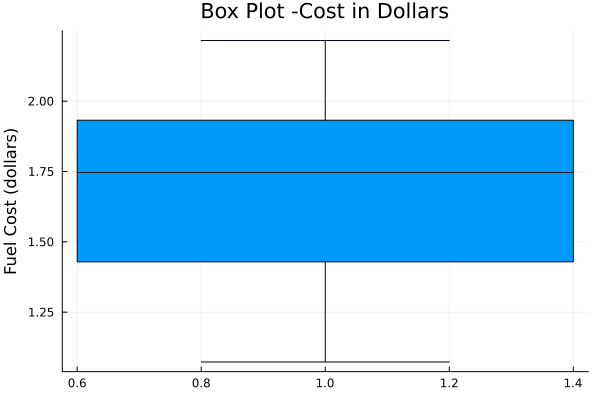

In [20]:
cid_bxplt = boxplot(df.Cost_in_Dollars, title = "Box Plot -Cost in Dollars", ylabel = "Fuel Cost (dollars)", legend = false)
savefig("JuliaPlots/boxplot_FuelCost.png")
cid_bxplt

In [21]:
# Outlier removal
first_percentile = percentile(df.Cost_in_Dollars, 25)
iqr_value = iqr(df.Cost_in_Dollars)
df = df[df.Cost_in_Dollars .>  (first_percentile - 1.5*iqr_value),:];

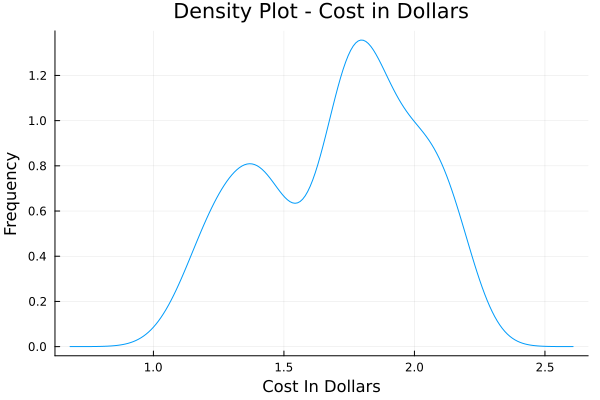

In [22]:
# Density Plot
density_cid = density(df.Cost_in_Dollars , title = "Density Plot - Cost in Dollars", ylabel = "Frequency", xlabel = "Cost In Dollars", legend = false)
savefig("JuliaPlots/DensityPlot_CID.png")
density_cid

In [23]:
df_fuelprice_dollars

,Week,Fuel_Type,Cost_in_Dollars
,Date…,String,Float64
1,2008-01-04,Diesel price,1.234
2,2008-01-04,Regular petrol price,1.697
3,2008-01-04,Premium petrol 95R price,1.78985
4,2008-01-11,Diesel price,1.284
5,2008-01-11,Regular petrol price,1.74
6,2008-01-11,Premium petrol 95R price,1.78985
7,2008-01-18,Diesel price,1.263
8,2008-01-18,Regular petrol price,1.718
9,2008-01-18,Premium petrol 95R price,1.73984


In [24]:
for data in eachrow(df_fuelprice_dollars.Fuel_Type)
    println(data)
end

["Diesel price "]
["Regular petrol price "]
["Premium petrol 95R price "]
["Diesel price "]
["Regular petrol price "]
["Premium petrol 95R price "]
["Diesel price "]
["Regular petrol price "]
["Premium petrol 95R price "]
["Diesel price "]
["Regular petrol price "]
["Premium petrol 95R price "]
["Diesel price "]
["Regular petrol price "]
["Premium petrol 95R price "]
["Diesel price "]
["Regular petrol price "]
["Premium petrol 95R price "]
["Diesel price "]
["Regular petrol price "]
["Premium petrol 95R price "]
["Diesel price "]
["Regular petrol price "]
["Premium petrol 95R price "]
["Diesel price "]
["Regular petrol price "]
["Premium petrol 95R price "]
["Diesel price "]
["Regular petrol price "]
["Premium petrol 95R price "]
["Diesel price "]
["Regular petrol price "]
["Premium petrol 95R price "]
["Diesel price "]
["Regular petrol price "]
["Premium petrol 95R price "]
["Diesel price "]
["Regular petrol price "]
["Premium petrol 95R price "]
["Diesel price "]
["Regular petrol pri

In [25]:
# clean the fields
df_fuelprice_dollars.Fuel_Type = replace(df_fuelprice_dollars.Fuel_Type, "Diesel price " => "Diesel")
df_fuelprice_dollars.Fuel_Type = replace(df_fuelprice_dollars.Fuel_Type, "Regular petrol price " => "Regular petrol")
df_fuelprice_dollars.Fuel_Type = replace(df_fuelprice_dollars.Fuel_Type, "Premium petrol 95R price " => "Premium petrol 95R")

# Filter the DataFrame for "Diesel" fuel type

df_diesel = filter(row -> row.Fuel_Type == "Diesel", df_fuelprice_dollars)

# Filter the DataFrame for "Regular petrol" fuel type
df_regular_petrol = filter(row -> row.Fuel_Type == "Regular petrol", df_fuelprice_dollars)

df_premium_petrol = filter(row -> row.Fuel_Type == "Premium petrol 95R", df_fuelprice_dollars)

# Display the separate DataFrames
println("DataFrame for Diesel:")
println(df_diesel)

println("\nDataFrame for Regular petrol:")
println(df_regular_petrol)

println("\nDataFrame for Premium petrol:")
println(df_premium_petrol)

unique_fuel_types = unique(df_fuelprice_dollars.Fuel_Type)
println(unique_fuel_types)

cor_df = DataFrame(
    Diesel = df_diesel.Cost_in_Dollars,
    Regular_Petrol = df_regular_petrol.Cost_in_Dollars
    )
cor_df

DataFrame for Diesel:
52×3 DataFrame
 Row │ Week        Fuel_Type  Cost_in_Dollars 
     │ Date…       String     Float64         
─────┼────────────────────────────────────────
   1 │ 2008-01-04  Diesel             1.234
   2 │ 2008-01-11  Diesel             1.284
   3 │ 2008-01-18  Diesel             1.263
   4 │ 2008-01-25  Diesel             1.235
   5 │ 2008-02-01  Diesel             1.235
   6 │ 2008-02-08  Diesel             1.199
   7 │ 2008-02-15  Diesel             1.184
   8 │ 2008-02-22  Diesel             1.236
   9 │ 2008-02-29  Diesel             1.265
  10 │ 2008-03-07  Diesel             1.265
  11 │ 2008-03-14  Diesel             1.297
  12 │ 2008-03-21  Diesel             1.31
  13 │ 2008-03-28  Diesel             1.31
  14 │ 2008-04-04  Diesel             1.362
  15 │ 2008-04-11  Diesel             1.393
  16 │ 2008-04-18  Diesel             1.456
  17 │ 2008-04-25  Diesel             1.528
  18 │ 2008-05-02  Diesel             1.555
  19 │ 2008-05-09  Diesel       

,Diesel,Regular_Petrol
,Float64,Float64
1,1.234,1.697
2,1.284,1.74
3,1.263,1.718
4,1.235,1.69
5,1.235,1.69
6,1.199,1.69
7,1.184,1.661
8,1.236,1.696
9,1.265,1.73


In [26]:
df_diesel

,Week,Fuel_Type,Cost_in_Dollars
,Date…,String,Float64
1,2008-01-04,Diesel,1.234
2,2008-01-11,Diesel,1.284
3,2008-01-18,Diesel,1.263
4,2008-01-25,Diesel,1.235
5,2008-02-01,Diesel,1.235
6,2008-02-08,Diesel,1.199
7,2008-02-15,Diesel,1.184
8,2008-02-22,Diesel,1.236
9,2008-02-29,Diesel,1.265


Correlation of Diesel with Regular Petrol 0.39247949173143604




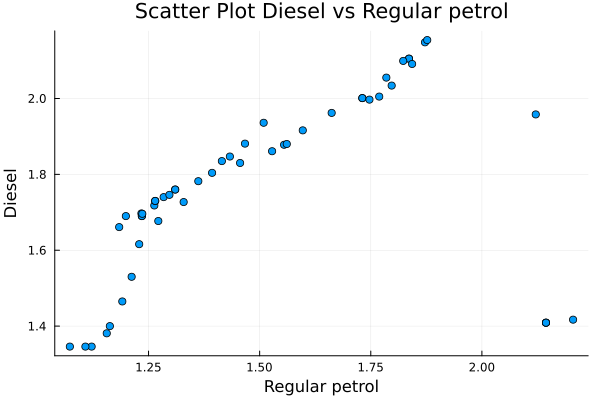

In [27]:
# Correlation Analysis
#println("Correlation of Life Expectancy with Adult Mortality Rate is ", cor(df.Regular_Petrol,df.Diesel), "\n\n")
println("Correlation of Diesel with Regular Petrol ", cor(df_diesel.Cost_in_Dollars,df_regular_petrol.Cost_in_Dollars), "\n\n")

# Scatter plot
train_plot = scatter(df_diesel.Cost_in_Dollars,df_regular_petrol.Cost_in_Dollars, title = "Scatter Plot Diesel vs Regular petrol", ylabel = "Diesel", xlabel = "Regular petrol",legend = false)
savefig("JuliaPlots/scatter_trainPlot.png")
train_plot

In [28]:
using Lathe.preprocess: TrainTestSplit
train, test = TrainTestSplit(cor_df,.75)

(41×2 DataFrame
 Row │ Diesel   Regular_Petrol 
     │ Float64  Float64        
─────┼─────────────────────────
   1 │ 1.234             1.697
   2 │ 1.284             1.74
   3 │ 1.235             1.69
   4 │ 1.235             1.69
   5 │ 1.184             1.661
   6 │ 1.236             1.696
   7 │ 1.265             1.73
   8 │ 1.265             1.73
   9 │ 1.297             1.746
  10 │ 1.31              1.76
  11 │ 1.31              1.76
  ⋮  │    ⋮           ⋮
  32 │ 1.467             1.881
  33 │ 1.433             1.847
  34 │ 1.415             1.835
  35 │ 1.329             1.727
  36 │ 1.272             1.677
  37 │ 1.212             1.53
  38 │ 1.163             1.4
  39 │ 1.156             1.381
  40 │ 1.122             1.346
  41 │ 1.108             1.346
                20 rows omitted, 11×2 DataFrame
 Row │ Diesel   Regular_Petrol 
     │ Float64  Float64        
─────┼─────────────────────────
   1 │ 1.263             1.718
   2 │ 1.199             1.69
   3 │ 1.362      

In [29]:
fm = @formula(Diesel ~ Regular_Petrol)
linearRegressor = lm(fm, train)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Diesel ~ 1 + Regular_Petrol

Coefficients:
───────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error     t  Pr(>|t|)   Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)     0.625595    0.361983  1.73    0.0919  -0.106586    1.35777
Regular_Petrol  0.496761    0.202777  2.45    0.0189   0.0866059   0.906915
───────────────────────────────────────────────────────────────────────────

In [30]:
# R Square value of the model
r2(linearRegressor)
#> 0.4548557168286279


0.13336172204832397

In [31]:
# Prediction
ypredicted_test = predict(linearRegressor, test)
ypredicted_train = predict(linearRegressor, train)

# Test Performance DataFrame (compute squared error)
performance_testdf = DataFrame(y_actual = test[!,:Diesel], y_predicted = ypredicted_test)
performance_testdf.error = performance_testdf[!,:y_actual] - performance_testdf[!,:y_predicted]
performance_testdf.error_sq = performance_testdf.error.*performance_testdf.error

# Train Performance DataFrame (compute squared error)
performance_traindf = DataFrame(y_actual = train[!,:Diesel], y_predicted = ypredicted_train)
performance_traindf.error = performance_traindf[!,:y_actual] - performance_traindf[!,:y_predicted]
performance_traindf.error_sq = performance_traindf.error.*performance_traindf.error ;

In [32]:
# MAPE function defination
function mape(performance_df)
    mape = mean(abs.(performance_df.error./performance_df.y_actual))
    return mape
end

mape (generic function with 1 method)

In [33]:
# RMSE function defination
function rmse(performance_df)
    rmse = sqrt(mean(performance_df.error.*performance_df.error))
    return rmse
end

rmse (generic function with 1 method)

In [34]:
# Test Error
println("Mean Absolute test error: ",mean(abs.(performance_testdf.error)), "\n")
println("Mean Aboslute Percentage test error: ",mape(performance_testdf), "\n")
println("Root mean square test error: ",rmse(performance_testdf), "\n")
println("Mean square test error: ",mean(performance_testdf.error_sq), "\n")

Mean Absolute test error: 0.2486435038068268

Mean Aboslute Percentage test error: 0.15990204370202457

Root mean square test error: 0.319968211703215

Mean square test error: 0.10237965650055339



In [35]:
# Train  Error
println("Mean train error: ",mean(abs.(performance_traindf.error)), "\n")
println("Mean Absolute Percentage train error: ",mape(performance_traindf), "\n")
println("Root mean square train error: ",rmse(performance_traindf), "\n")
println("Mean square train error: ",mean(performance_traindf.error_sq), "\n")

Mean train error: 0.20677289097525384

Mean Absolute Percentage train error: 0.13315764514231787

Root mean square train error: 0.2824178652521375

Mean square train error: 0.0797598506135745



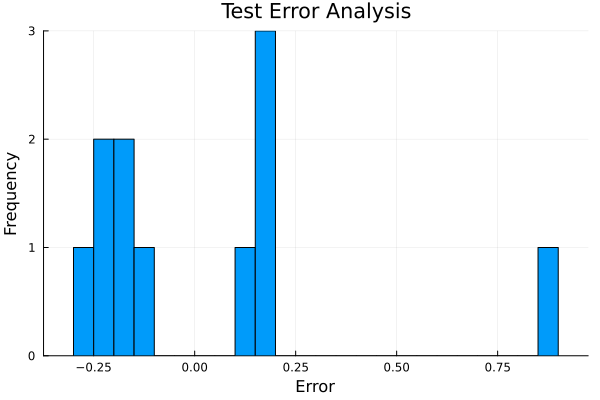

In [36]:
# Histogram of error to see if it's normally distributed  on test dataset
test_df_hist = histogram(performance_testdf.error, bins = 50, title = "Test Error Analysis", ylabel = "Frequency", xlabel = "Error",legend = false)
savefig("JuliaPlots/histogram_perfomance_testdf_error.png")
test_df_hist

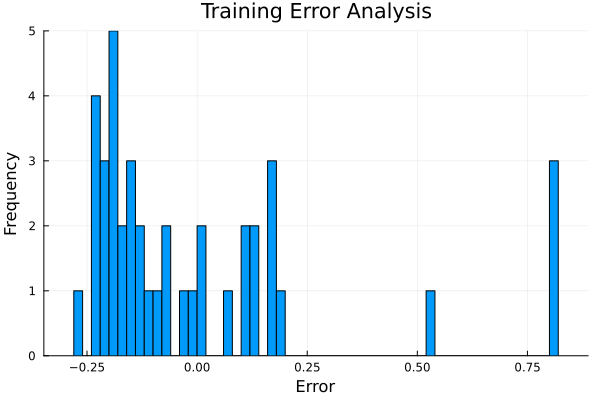

In [37]:
# Histogram of error to see if it's normally distributed  on train dataset
train_df_hist = histogram(performance_traindf.error, bins = 50, title = "Training Error Analysis", ylabel = "Frequency", xlabel = "Error",legend = false)
savefig("JuliaPlots/histogram_performance_traindf_error.png")
train_df_hist

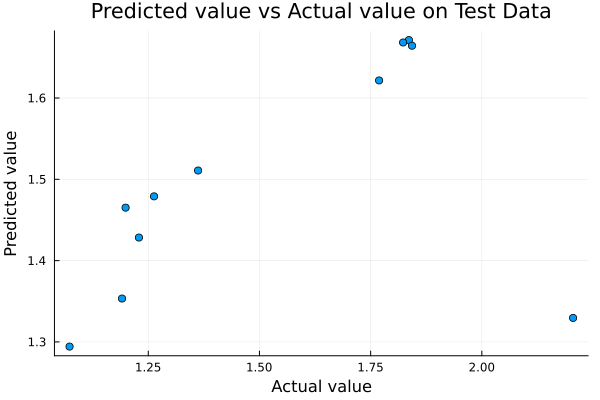

In [38]:
# Scatter plot of actual vs predicted values on test dataset
test_plot = scatter(performance_testdf[!,:y_actual],performance_testdf[!,:y_predicted], title = "Predicted value vs Actual value on Test Data", ylabel = "Predicted value", xlabel = "Actual value", legend = false)
savefig("JuliaPlots/scatter_performance_testdf_error.png")
test_plot

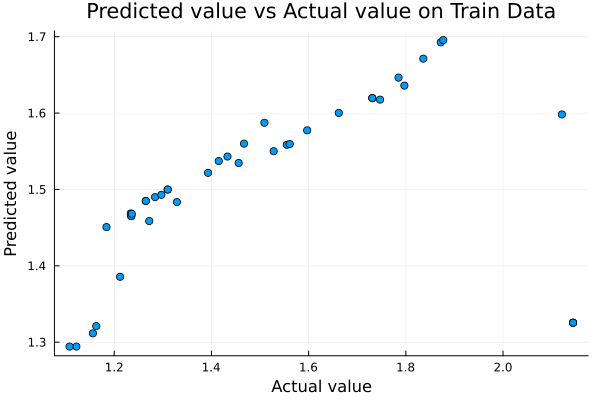

In [39]:
# Scatter plot of actual vs predicted values on train dataset
train_plot = scatter(performance_traindf[!,:y_actual],performance_traindf[!,:y_predicted], title = "Predicted value vs Actual value on Train Data", ylabel = "Predicted value", xlabel = "Actual value",legend = false)
savefig("JuliaPlots/scatter_performance_traindf.png")
train_plot

In [40]:
function find_smallest_k(dataset)
     # Create an array of Float64 values    
    # Find the index of the smallest value in the array
    min_index = argmin(dataset)
    # Get the smallest value itself
    min_value = dataset[min_index]
    
    # Print the smallest value and its location
    println("Mean error for set $min_index is the smallest value ", min_value)
    #println("Location (Index):", min_index)
end

find_smallest_k (generic function with 1 method)

In [41]:
# Cross Validation function defination
function cross_validation(train,k, fm = @formula(Diesel ~ Regular_Petrol))   
    a = collect(Kfold(size(train)[1], k))
    mean_data_points = []
    for i in 1:k
        row = a[i]
        temp_train = train[row,:]
        temp_test = train[setdiff(1:end, row),:]
        linearRegressor = lm(fm, temp_train)
        performance_testdf = DataFrame(y_actual = temp_test[!,:Diesel], y_predicted = predict(linearRegressor, temp_test))
        performance_testdf.error = performance_testdf[!,:y_actual] - performance_testdf[!,:y_predicted]

        println("Mean error for set $i is ",mean(abs.(performance_testdf.error)))
        push!(mean_data_points,  mean(abs.(performance_testdf.error)))
    end
    find_smallest_k(mean_data_points)
end

cross_validation (generic function with 2 methods)

In [42]:
cross_validation(train,10)

Mean error for set 1 is 0.32534953176786513
Mean error for set 2 is 0.19987618043607291
Mean error for set 3 is 0.1836702950781573
Mean error for set 4 is 0.3022259037385636
Mean error for set 5 is 0.17127540829711563
Mean error for set 6 is 0.2461296967211059
Mean error for set 7 is 0.15086415793484098
Mean error for set 8 is 0.1582831807791511
Mean error for set 9 is 0.14969653057315335
Mean error for set 10 is 0.2830306141309221
Mean error for set 9 is the smallest value 0.14969653057315335


In [43]:
# max k-fold validation based on train size!
#cross_validation(train,size(train)[1])


In [44]:
cross_validation(train,size(train)[1])

Mean error for set 1 is 0.09590799431003139
Mean error for set 2 is 0.06448586820703883
Mean error for set 3 is 0.23665621209279908
Mean error for set 4 is 0.17095632388131898
Mean error for set 5 is 0.003619472303512117
Mean error for set 6 is 0.27505907908803584
Mean error for set 7 is 0.13609843673972777
Mean error for set 8 is 0.8983133686572982
Mean error for set 9 is 0.020316750174414366
Mean error for set 10 is 0.5455550425720439
Mean error for set 11 is 0.8983133686572982
Mean error for set 12 is 0.001542125304243358
Mean error for set 13 is 0.20996594831577386
Mean error for set 14 is 0.14802124517957416
Mean error for set 15 is 0.174062683590831
Mean error for set 16 is 0.8983133686572982
Mean error for set 17 is 0.08139295090921395
Mean error for set 18 is 0.22568217430306192
Mean error for set 19 is 0.19465266636237488
Mean error for set 20 is 0.0807737092615437
Mean error for set 21 is 0.12546109937520633
Mean error for set 22 is 0.17272656218013172
Mean error for set 23 i

In [45]:
# cluster analysis

using RDatasets, Clustering
 
# loading the dataset
iris = dataset("datasets", "iris"); 
 
# features for clustering
features = collect(Matrix(iris[:, 1:4])'); 
 
# result after running K-means for the 3 clusters
result = kmeans(features, 3); 
 
# plotting the result
s_result = scatter(iris.PetalLength, iris.PetalWidth, 
        marker_z = result.assignments,
        color =:lightrainbow, legend = false)
 
# saving the result in PNG form
savefig("JuliaPlots/cluster_scatter_iris.png")

"/mnt/c/DATA422 Group Project/Temp_Code/Master/JuliaPlots/cluster_scatter_iris.png"

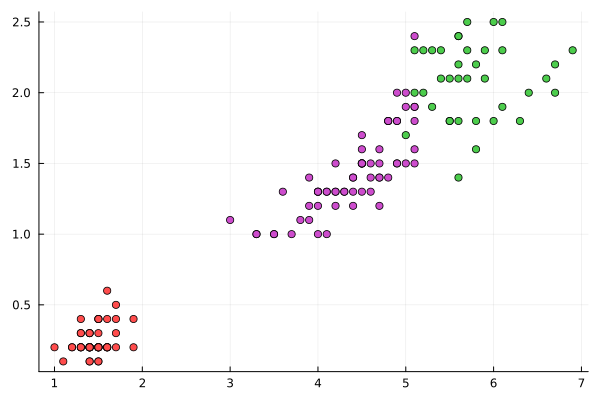

In [46]:
s_result

In [47]:
# cluster of ours
using Clustering

# loading the dataset
fuel_cluster = DataFrame(
    Diesel = df_diesel.Cost_in_Dollars,
    Regular_Petrol = df_regular_petrol.Cost_in_Dollars
    )
 
# features for clustering
features = collect(Matrix(fuel_cluster[:, 1:2])'); 
 
# result after running K-means for the 3 clusters
result = kmeans(features, 3); 
 
# plotting the result
fuel_result = scatter(fuel_cluster.Diesel, fuel_cluster.Regular_Petrol, 
        marker_z = result.assignments,
        color =:lightrainbow, legend = false)
 
# saving the result in PNG form
savefig("JuliaPlots/cluster_scatter_fuel_types.png")

"/mnt/c/DATA422 Group Project/Temp_Code/Master/JuliaPlots/cluster_scatter_fuel_types.png"

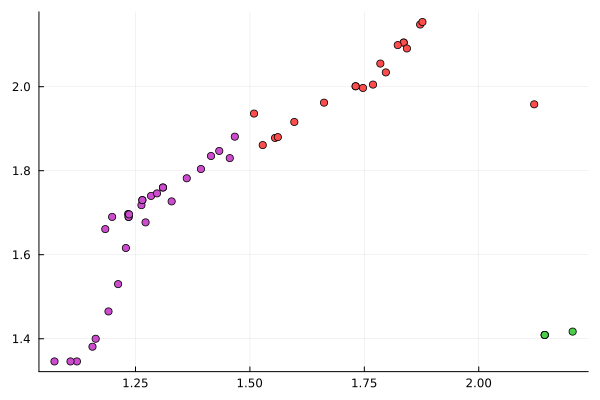

In [48]:
fuel_result

In [49]:
function find_lowest_price(dataset)
    # Create an array of Float64 values    
    # Find the index of the smallest value in the array
    min_index = argmin(dataset)
    # Get the smallest value itself
    min_value = dataset[min_index]
    
    # Print the smallest value and its location
    println("The index is: $min_index is the smallest fuel price ", min_value/100)
    #println("Location (Index):", min_index)
    return(min_value / 100)
end

find_lowest_price (generic function with 1 method)

In [50]:
function long_df_process(dataset)
    dataset.Fuel_Type = replace(dataset.Fuel_Type, "Diesel price " => "Diesel")
    dataset.Fuel_Type = replace(dataset.Fuel_Type, "Regular petrol price " => "Regular petrol")
    dataset.Fuel_Type = replace(dataset.Fuel_Type, "Premium petrol 95R price " => "Premium petrol 95R")
    
    temp_df_diesel = filter(row -> row.Fuel_Type == "Diesel", dataset)

    # Filter the DataFrame for "Regular petrol" fuel type
    temp_df_reg_petrol = filter(row -> row.Fuel_Type == "Regular petrol", dataset)

    # Filter the DataFrame for "Regular petrol" fuel type
    temp_df_premium = filter(row -> row.Fuel_Type == "Premium petrol 95R", dataset)
    compiled_df = DataFrame(
        Regular_Petrol = temp_df_reg_petrol.Value,
        Diesel = temp_df_diesel.Value,
        Premium_Petrol = temp_df_premium.Value,
    )
    return(compiled_df)
end

long_df_process (generic function with 1 method)

In [51]:
# create longdf
longdf_year = []
for data in weekly_energy_prices.Week Number
    date_to_string = string(data)
    year = split(date_to_string,"-")[1]
    if !(year in longdf_year)
        push!(longdf_year, year)
    end
end

In [52]:
new_df = DataFrame()
for data in longdf_year
    year_text = "$data"
    long_df_target = long_df_process(compile_year_data("$data", weekly_energy_prices))# |> long_df_process
    #long_df_target = long_df_process(compile_year_data("$data", weekly_energy_prices))
    #println(long_df_target)
    Diesel = find_lowest_price(long_df_target.Diesel)
    Regular_Petrol = find_lowest_price(long_df_target.Regular_Petrol)

    min_value_df = DataFrame(
        Year = data,
        Diesel = find_lowest_price(long_df_target.Diesel),
        Regular_Petrol = find_lowest_price(long_df_target.Regular_Petrol),
        Premium_Petrol_95R = find_lowest_price(long_df_target.Premium_Petrol) 
    )
    for row in eachrow(min_value_df)
        push!(new_df, row)
    end
end

The index is: 2 is the smallest fuel price 0.66
The index is: 13 is the smallest fuel price 0.675
The index is: 2 is the smallest fuel price 0.66
The index is: 13 is the smallest fuel price 0.675
The index is: 35 is the smallest fuel price 1.1490033333
The index is: 1 is the smallest fuel price 0.735
The index is: 49 is the smallest fuel price 0.7979999999999999
The index is: 1 is the smallest fuel price 0.735
The index is: 49 is the smallest fuel price 0.7979999999999999
The index is: 1 is the smallest fuel price 1.179
The index is: 45 is the smallest fuel price 0.9790000000000001
The index is: 1 is the smallest fuel price 1.368
The index is: 45 is the smallest fuel price 0.9790000000000001
The index is: 1 is the smallest fuel price 1.368
The index is: 44 is the smallest fuel price 1.4276824298
The index is: 3 is the smallest fuel price 0.9129999999999999
The index is: 3 is the smallest fuel price 1.3519999999999999
The index is: 3 is the smallest fuel price 0.9129999999999999
The ind

In [53]:
new_df

,Year,Diesel,Regular_Petrol,Premium_Petrol_95R
,SubStri…,Float64,Float64,Float64
1,2004,0.66,0.675,1.149
2,2005,0.735,0.798,1.179
3,2006,0.979,1.368,1.42768
4,2007,0.913,1.352,1.4019
5,2008,1.073,1.346,1.38047
6,2009,0.963,1.32,1.37851
7,2010,1.051,1.627,1.71669
8,2011,1.28508,1.37219,2.00985
9,2012,1.38667,1.26324,2.00591


In [54]:
# features for clustering
features = collect(Matrix(new_df[:, 2:3])'); 
 
# result after running K-means for the 3 clusters
result = kmeans(features, 3); 
 
# plotting the result
fuel_result = scatter(new_df.Diesel, new_df.Regular_Petrol, 
        marker_z = result.assignments,
        color =:lightrainbow, legend = false)
 
# saving the result in PNG form
savefig("JuliaPlots/cluster_scatter_fuel_types_year.png")

"/mnt/c/DATA422 Group Project/Temp_Code/Master/JuliaPlots/cluster_scatter_fuel_types_year.png"

In [55]:
?RData

search: RData RDatasets RDataException df_year_data AbstractDataFrame



No docstring found for module `RData`.

# Exported names

`CodecMissingError`, `DictoVec`, `RDataException`, `UnsupportedROBJ`, `load`, `sexp2julia`

# Displaying contents of readme found at `/home/sil/.julia/packages/RData/OT7M6/README.md`

# RData.jl

[![CI](https://github.com/JuliaData/RData.jl/workflows/CI/badge.svg)](https://github.com/JuliaData/RData.jl/actions?query=workflow%3ACI+branch%3Amain) [![codecov](https://codecov.io/gh/JuliaData/RData.jl/branch/main/graph/badge.svg)](https://codecov.io/gh/JuliaData/RData.jl) [![deps](https://juliahub.com/docs/RData/deps.svg)](https://juliahub.com/ui/Packages/RData/idMMA?t=2) [![version](https://juliahub.com/docs/RData/version.svg)](https://juliahub.com/ui/Packages/RData/idMMA) [![pkgeval](https://juliahub.com/docs/RData/pkgeval.svg)](https://juliahub.com/ui/Packages/RData/idMMA)

Read R data files (.rda, .RData) and optionally convert the contents into Julia equivalents.

Can read any R data archive, although not all R types could be converted into Julia.

For running R code from Julia see [RCall.jl](https://github.com/JuliaInterop/RCall.jl).

## Installation

From Julia REPL:

```julia
Pkg.add("RData")
```

### Compression formats

R data files could be compressed by either *Gzip* (the default), *Bzip2* or *Xz* methods. `RData.jl` supports *Gzip*-compressed files out-of-the-box. To read *Bzip2* or *Xz*-compressed files [CodecBzip2.jl](https://github.com/bicycle1885/CodecBzip2.jl) or [CodecXz.jl](https://github.com/bicycle1885/CodecXz.jl) must be installed.

For example, to load a file compressed by *Bzip2* you must first install the required codec:

```julia
Pkg.add("CodecBzip2")
```

Then ensure *CodecBzip2* is loaded before calling *RData.load*:

```julia
using RData
import CodecBzip2

load('some_bzip2_compressed.rda')
```

## Usage

To read R objects from "example.rda" file:

```julia
using RData

objs = load("path_to/example.rda")
```

The result is a dictionary (`Dict{String, Any}`) of all R objects stored in "example.rda".

If `convert=true` keyword option is specified, `load()` will try to automatically convert R objects into Julia equivalents:

| R object     | Julia object           |  | |–––––––|––––––––––––|–| | named vector, list | `DictoVec` | `DictoVec` allows indexing both by element index and by its name, just as R vectors and lists | | vector    | `Vector{T}` | `T` is the appropriate Julia type. If R vector contains `NA` values, they are converted to [`missing`](https://github.com/JuliaData/Missings.jl), and the elements type of the resulting `Vector` is `Union{T, Missing}`. | factor     | `CategoricalArray` | [CategoricalArrays.jl](https://github.com/JuliaData/CategoricalArrays.jl) | | `Date`     | `Dates.Date` | | | `POSIXct` date time | `ZonedDateTime` | [TimeZones.jl](https://github.com/JuliaTime/TimeZones.jl) | | data frame | `DataFrame` | [DataFrames.jl](https://github.com/JuliaData/DataFrames.jl) | | `compact_xxxseq` | `UnitRange`/`StepRange` | |

If conversion to the Julia type is not supported (e.g. R closure or language expression), `load()` will return the internal RData representation of the object (`RSEXPREC` subtype).


In [56]:
using RCall

In [57]:
@rput new_df

# Save the R DataFrame as an RData file using R's save function
R"save(new_df, file='./Datasets/prices_long.rda')"

RObject{NilSxp}
NULL


__Final Dataset for model to use__

In [58]:
# prep for graphs
combinedfinal = load("./Datasets/combinedfinal.rda", convertdataframes=true)
combinedfinal = combinedfinal["combinedfinal"]

,Year,FuelCost,price,Brand,Model,TankSize,Fuelefficiency,Range,KM_10vehicles_26refuels,FuelCosts_10vehicles
,String,String,Float64,String,String,Float64,Float64,Float64,Float64,Float64
1,2004,Diesel,0.66,Ford,Ranger,80.0,9.0,857.566,2.22967e5,13728.0
2,2004,Diesel,0.66,Mitsubishi,Triton,75.0,9.5,798.656,2.07651e5,12870.0
3,2004,Diesel,0.66,Toyota,HiLux,80.0,7.5,1024.89,2.6647e5,13728.0
4,2004,Diesel,0.66,Isuzu,D-Max,76.0,7.5,1093.1,2.84205e5,13041.6
5,2004,Diesel,0.66,Hyundai,Santa Fe,67.0,6.5,1047.24,2.72284e5,11497.2
6,2005,Diesel,0.735,Ford,Ranger,80.0,9.0,847.865,220445.0,15288.0
7,2005,Diesel,0.735,Mitsubishi,Triton,75.0,9.5,813.845,2.116e5,14332.5
8,2005,Diesel,0.735,Toyota,HiLux,80.0,7.5,1103.58,2.86932e5,15288.0
9,2005,Diesel,0.735,Isuzu,D-Max,76.0,7.5,1042.12,2.70952e5,14523.6


In [59]:
combinedfinal |> describe

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,Year,,2004,,2023,0,String
2,FuelCost,,Diesel,,Regular_Petrol,0,String
3,price,1.41612,0.66,1.3701,2.30297,0,Float64
4,Brand,,Ford,,Volkswagen,0,String
5,Model,,Corolla,,X-Trail,0,String
6,TankSize,58.3333,37.0,55.0,80.0,0,Float64
7,Fuelefficiency,6.73333,2.0,6.5,9.5,0,Float64
8,Range,959.702,519.667,832.601,2924.88,0,Float64
9,KM_10vehicles_26refuels,2.49523e5,1.35113e5,2.16476e5,7.6047e5,0,Float64


In [60]:
# useful fields  and code

# dissd_noall = dissd |>
#   @filter(_.Entity .!= "All natural disasters") |>
#   DataFrame

In [61]:
# to randomise data incase wanting to randomise the graph in R
# combinedfinal <- combinedfinal %>%
#   rowwise() %>%
#   mutate(
#     Range = runif(1, min = 300, max = 500),
#     KM_10vehicles_26refuels = 10 * Range * 26,
#     FuelCosts_10vehicles = 10 * TankSize * 26 * price
#   ) %>%
#   ungroup() %>%
#   select(Year, FuelCost, price, Brand, Model, TankSize, Fuelefficiency, Range, KM_10vehicles_26refuels, FuelCosts_10vehicles)

In [62]:
# Fix column names by replacing ' ', '-', '/' with '_'
colnames = Symbol[]
for i in string.(names(combinedfinal))
    push!(colnames,Symbol(replace(replace(replace(strip(i)," " => "_"),"-" => "_"), "/" => "_")))
end

rename!(combinedfinal, colnames);

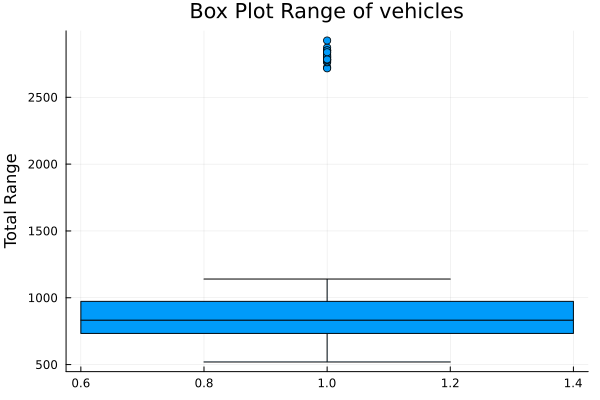

In [63]:
cid_bxplt = boxplot(combinedfinal.Range, title = "Box Plot Range of vehicles", ylabel = "Total Range", legend = false)
savefig("JuliaPlots/comfinedfinal_unclean_boxplot_FuelCost.png")
cid_bxplt

In [66]:
"""
Plot the data guideline
l_value = "Premium petrol 95R"
l_column = "Fuel_Type"
c_toplot = "Cost in Dollars"
figname = "lineplot_prem_petrol"
plot_data(df_fuelprice_dollars, l_value, l_column, c_toplot, figname)
"""

"Plot the data guideline\nl_value = \"Premium petrol 95R\"\nl_column = \"Fuel_Type\"\nc_toplot = \"Cost in Dollars\"\nfigname = \"lineplot_prem_petrol\"\nplot_data(df_fuelprice_dollars, l_value, l_column, c_toplot, figname)\n"

In [67]:
# cluster of ours
using Clustering

# loading the dataset
fuel_cluster = DataFrame(
    Range = combinedfinal.Range,
    Fuel_Cost = combinedfinal.price
    )
 
# features for clustering
features = collect(Matrix(fuel_cluster[:, 1:2])'); 
 
# result after running K-means for the 3 clusters
result = kmeans(features, 3); 
 
# plotting the result
fuel_result = scatter(fuel_cluster.Range, fuel_cluster.Fuel_Cost,
        marker_z = result.assignments,
        color =:lightrainbow, legend = false)
 
# saving the result in PNG form
savefig("JuliaPlots/combinedfinal_cluster_scatter_fuel_types.png")

"/mnt/c/DATA422 Group Project/Temp_Code/Master/JuliaPlots/combinedfinal_cluster_scatter_fuel_types.png"

In [68]:
# Load the installed packages
using Lathe, GLM, Statistics, StatsPlots, MLBase

# Enable printing of 1000 columns
ENV["COLUMNS"] = 1000

1000

In [69]:
# Fix column names by replacing ' ', '-', '/' with '_'
colnames = Symbol[]
for i in string.(names(combinedfinal))
    push!(colnames,Symbol(replace(replace(replace(strip(i)," " => "_"),"-" => "_"), "/" => "_")))
end

rename!(combinedfinal, colnames);

In [89]:
fuel_frequency = combine(groupby(combinedfinal, :FuelCost), nrow => :Freq)

,FuelCost,Freq
,String,Int64
1,Diesel,100
2,Regular_Petrol,180
3,Premium_Petrol_95R,20


In [71]:
df_diesel = filter(row -> row.FuelCost == "Diesel", combinedfinal)

# Filter the DataFrame for "Regular petrol" fuel type
df_regular_petrol = filter(row -> row.FuelCost == "Regular_Petrol", combinedfinal)

df_premium_petrol = filter(row -> row.FuelCost == "Premium_Petrol_95R", combinedfinal)

# Display the separate DataFrames
println("DataFrame for Diesel:")
println(df_diesel)

println("\nDataFrame for Regular petrol:")
println(df_regular_petrol)

println("\nDataFrame for Premium petrol:")
println(df_premium_petrol)

unique_fuel_types = unique(combinedfinal.FuelCost)
println(unique_fuel_types)
print(length(df_diesel.KM_10vehicles_26refuels))
# make sure the two columns have the same length unfortunately this means data is lost!
cor_df = DataFrame(
    Diesel = df_diesel.KM_10vehicles_26refuels,
    Regular_Petrol = df_regular_petrol.KM_10vehicles_26refuels[1:fuel_frequency.Diesel[:Frequency]]
    )
cor_df

DataFrame for Diesel:
100×10 DataFrame
 Row │ Year    FuelCost  price     Brand       Model     TankSize  Fuelefficiency  Range     KM_10vehicles_26refuels  FuelCosts_10vehicles 
     │ String  String    Float64   String      String    Float64   Float64         Float64   Float64                  Float64              
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 2004    Diesel    0.66      Ford        Ranger        80.0             9.0   857.566                2.22967e5               13728.0
   2 │ 2004    Diesel    0.66      Mitsubishi  Triton        75.0             9.5   798.656                2.07651e5               12870.0
   3 │ 2004    Diesel    0.66      Toyota      HiLux         80.0             7.5  1024.89                 2.6647e5                13728.0
   4 │ 2004    Diesel    0.66      Isuzu       D-Max         76.0             7.5  1093.1                  2.84205e5        

,Diesel,Regular_Petrol
,Float64,Float64
1,2.22967e5,2.11935e5
2,2.07651e5,2.36911e5
3,2.6647e5,1.53334e5
4,2.84205e5,2.02054e5
5,2.72284e5,1.5149e5
6,220445.0,1.97884e5
7,2.116e5,7.37317e5
8,2.86932e5,216118.0
9,2.70952e5,1.90709e5


In [72]:
df_diesel

,Year,FuelCost,price,Brand,Model,TankSize,Fuelefficiency,Range,KM_10vehicles_26refuels,FuelCosts_10vehicles
,String,String,Float64,String,String,Float64,Float64,Float64,Float64,Float64
1,2004,Diesel,0.66,Ford,Ranger,80.0,9.0,857.566,2.22967e5,13728.0
2,2004,Diesel,0.66,Mitsubishi,Triton,75.0,9.5,798.656,2.07651e5,12870.0
3,2004,Diesel,0.66,Toyota,HiLux,80.0,7.5,1024.89,2.6647e5,13728.0
4,2004,Diesel,0.66,Isuzu,D-Max,76.0,7.5,1093.1,2.84205e5,13041.6
5,2004,Diesel,0.66,Hyundai,Santa Fe,67.0,6.5,1047.24,2.72284e5,11497.2
6,2005,Diesel,0.735,Ford,Ranger,80.0,9.0,847.865,220445.0,15288.0
7,2005,Diesel,0.735,Mitsubishi,Triton,75.0,9.5,813.845,2.116e5,14332.5
8,2005,Diesel,0.735,Toyota,HiLux,80.0,7.5,1103.58,2.86932e5,15288.0
9,2005,Diesel,0.735,Isuzu,D-Max,76.0,7.5,1042.12,2.70952e5,14523.6


Correlation of Diesel with Regular Petrol 0.30355930493130745




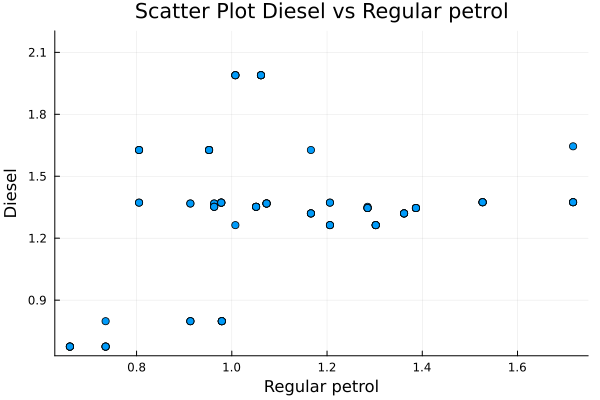

In [73]:
# Correlation Analysis
#println("Correlation of Life Expectancy with Adult Mortality Rate is ", cor(df.Regular_Petrol,df.Diesel), "\n\n")
println("Correlation of Diesel with Regular Petrol ", cor(df_diesel.price,df_regular_petrol.price[1:length(df_diesel.price)]), "\n\n")

# Scatter plot
train_plot = scatter(df_diesel.price,df_regular_petrol.price, title = "Scatter Plot Diesel vs Regular petrol", ylabel = "Diesel", xlabel = "Regular petrol",legend = false)
savefig("JuliaPlots/combinedfinal_scatter_trainPlot.png")
train_plot

In [74]:
using Lathe.preprocess: TrainTestSplit
train, test = TrainTestSplit(cor_df,.75)
fm = @formula(Diesel ~ Regular_Petrol)
linearRegressor = lm(fm, train)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Diesel ~ 1 + Regular_Petrol

Coefficients:
────────────────────────────────────────────────────────────────────────────────
                     Coef.    Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────────
(Intercept)      2.53579e5  6357.75       39.89    <1e-50   2.40908e5  2.6625e5
Regular_Petrol  -0.0149047     0.0219965  -0.68    0.5002  -0.0587437  0.0289343
────────────────────────────────────────────────────────────────────────────────

In [75]:

# R Square value of the model
r2(linearRegressor)
#> 0.4548557168286279

0.006250184071525333

In [76]:
# Prediction
ypredicted_test = predict(linearRegressor, test)
ypredicted_train = predict(linearRegressor, train)

# Test Performance DataFrame (compute squared error)
performance_testdf = DataFrame(y_actual = test[!,:Diesel], y_predicted = ypredicted_test)
performance_testdf.error = performance_testdf[!,:y_actual] - performance_testdf[!,:y_predicted]
performance_testdf.error_sq = performance_testdf.error.*performance_testdf.error

# Train Performance DataFrame (compute squared error)
performance_traindf = DataFrame(y_actual = train[!,:Diesel], y_predicted = ypredicted_train)
performance_traindf.error = performance_traindf[!,:y_actual] - performance_traindf[!,:y_predicted]
performance_traindf.error_sq = performance_traindf.error.*performance_traindf.error ;

In [77]:
# MAPE function defination
function mape(performance_df)
    mape = mean(abs.(performance_df.error./performance_df.y_actual))
    return mape
end

# RMSE function defination
function rmse(performance_df)
    rmse = sqrt(mean(performance_df.error.*performance_df.error))
    return rmse
end

# RMSE function defination
function rmse(performance_df)
    rmse = sqrt(mean(performance_df.error.*performance_df.error))
    return rmse
end

rmse (generic function with 1 method)

In [78]:
# Test Error
println("Mean Absolute test error: ",mean(abs.(performance_testdf.error)), "\n")
println("Mean Aboslute Percentage test error: ",mape(performance_testdf), "\n")
println("Root mean square test error: ",rmse(performance_testdf), "\n")
println("Mean square test error: ",mean(performance_testdf.error_sq), "\n")

Mean Absolute test error: 26373.83380463677

Mean Aboslute Percentage test error: 0.11160246090317745

Root mean square test error: 30704.166119081252

Mean square test error: 9.42745817068137e8



In [79]:
# Train  Error
println("Mean train error: ",mean(abs.(performance_traindf.error)), "\n")
println("Mean Absolute Percentage train error: ",mape(performance_traindf), "\n")
println("Root mean square train error: ",rmse(performance_traindf), "\n")
println("Mean square train error: ",mean(performance_traindf.error_sq), "\n")

Mean train error: 25871.14822754437

Mean Absolute Percentage train error: 0.10743373420107559

Root mean square train error: 29641.988688474376

Mean square train error: 8.786474934076428e8



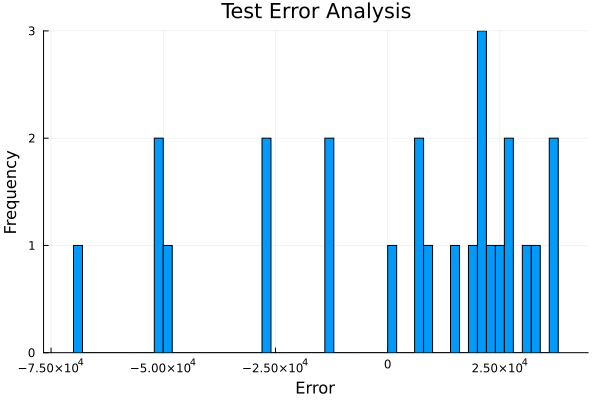

In [80]:
# Histogram of error to see if it's normally distributed  on test dataset
test_df_hist = histogram(performance_testdf.error, bins = 50, title = "Test Error Analysis", ylabel = "Frequency", xlabel = "Error",legend = false)
savefig("JuliaPlots/combinedfinal_histogram_perfomance_testdf_error.png")
test_df_hist

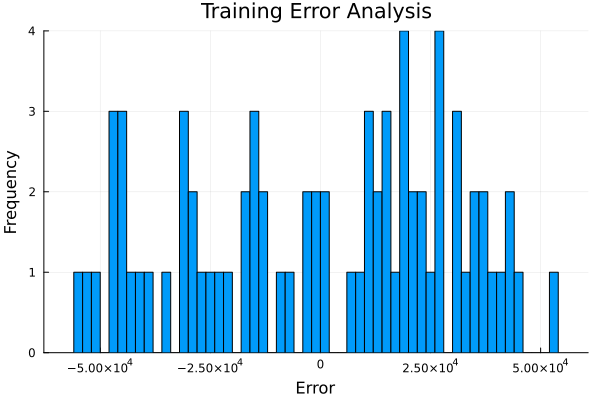

In [81]:
# Histogram of error to see if it's normally distributed  on train dataset
train_df_hist = histogram(performance_traindf.error, bins = 50, title = "Training Error Analysis", ylabel = "Frequency", xlabel = "Error",legend = false)
savefig("JuliaPlots/combinedfinal_histogram_performance_traindf_error.png")
train_df_hist

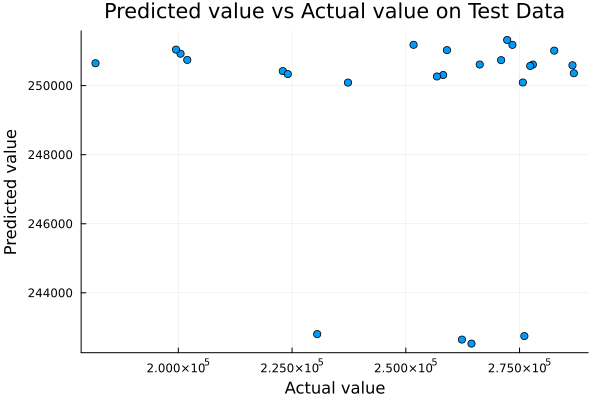

In [82]:
# Scatter plot of actual vs predicted values on test dataset
test_plot = scatter(performance_testdf[!,:y_actual],performance_testdf[!,:y_predicted], title = "Predicted value vs Actual value on Test Data", ylabel = "Predicted value", xlabel = "Actual value", legend = false)
savefig("JuliaPlots/combinedfinal_scatter_performance_testdf_error.png")
test_plot

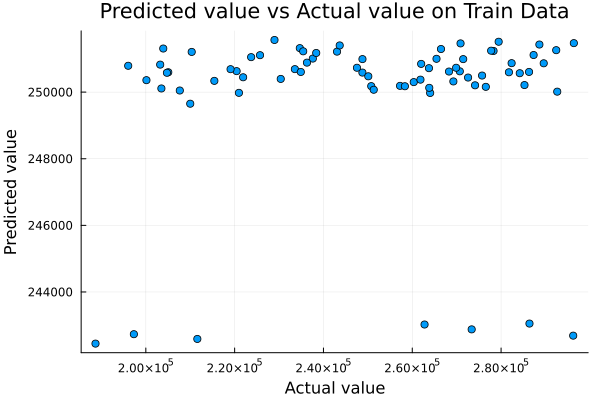

In [83]:
# Scatter plot of actual vs predicted values on train dataset
train_plot = scatter(performance_traindf[!,:y_actual],performance_traindf[!,:y_predicted], title = "Predicted value vs Actual value on Train Data", ylabel = "Predicted value", xlabel = "Actual value",legend = false)
savefig("JuliaPlots/combinedfinal_scatter_performance_traindf.png")
train_plot

In [84]:
function find_smallest_k(dataset)
     # Create an array of Float64 values    
    # Find the index of the smallest value in the array
    min_index = argmin(dataset)
    # Get the smallest value itself
    min_value = dataset[min_index]
    
    # Print the smallest value and its location
    println("Mean error for set $min_index is the smallest value ", min_value)
    #println("Location (Index):", min_index)
end


# Cross Validation function defination
function cross_validation(train,k, fm = @formula(Diesel ~ Regular_Petrol))   
    a = collect(Kfold(size(train)[1], k))
    mean_data_points = []
    for i in 1:k
        row = a[i]
        temp_train = train[row,:]
        temp_test = train[setdiff(1:end, row),:]
        linearRegressor = lm(fm, temp_train)
        performance_testdf = DataFrame(y_actual = temp_test[!,:Diesel], y_predicted = predict(linearRegressor, temp_test))
        performance_testdf.error = performance_testdf[!,:y_actual] - performance_testdf[!,:y_predicted]

        println("Mean error for set $i is ",mean(abs.(performance_testdf.error)))
        push!(mean_data_points,  mean(abs.(performance_testdf.error)))
    end
    find_smallest_k(mean_data_points)
end

cross_validation (generic function with 2 methods)

In [85]:
cross_validation(train,10)

Mean error for set 1 is 30507.987235375203
Mean error for set 2 is 37060.73408657937
Mean error for set 3 is 29336.594631704666
Mean error for set 4 is 27115.628622642867
Mean error for set 5 is 20525.658010896652
Mean error for set 6 is 21765.507223321183
Mean error for set 7 is 31007.80284890012
Mean error for set 8 is 24440.51018209939
Mean error for set 9 is 27265.661889612144
Mean error for set 10 is 22408.73844680846
Mean error for set 5 is the smallest value 20525.658010896652


In [86]:
cross_validation(train,size(train)[1])

Mean error for set 1 is 42971.44162893825
Mean error for set 2 is 45774.073499197635
Mean error for set 3 is 22688.00045251829
Mean error for set 4 is 25818.117680391588
Mean error for set 5 is 50918.88779732422
Mean error for set 6 is 55588.78414786339
Mean error for set 7 is 36234.08973844786
Mean error for set 8 is 14826.46046491692
Mean error for set 9 is 34121.868500304234
Mean error for set 10 is 16945.822408806533
Mean error for set 11 is 26988.715557294345
Mean error for set 12 is 35390.851290601684
Mean error for set 13 is 17915.979278671643
Mean error for set 14 is 1268.8739555094799
Mean error for set 15 is 48233.778323874634
Mean error for set 16 is 16061.283054261497
Mean error for set 17 is 14692.072067705682
Mean error for set 18 is 7158.38705068393
Mean error for set 19 is 24264.645518975158
Mean error for set 20 is 8272.089017437713
Mean error for set 21 is 36211.86822066727
Mean error for set 22 is 3232.5422179906163
Mean error for set 23 is 20294.640347067645
Mean er

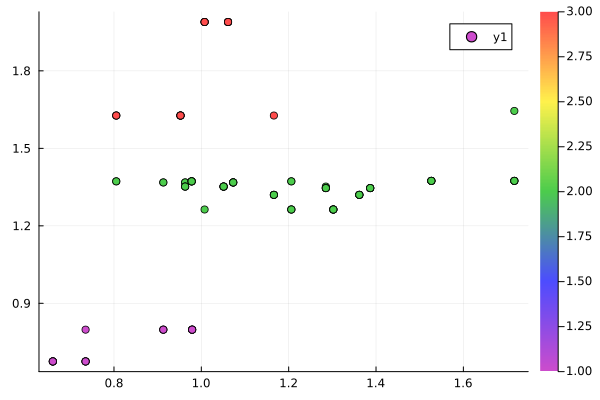

In [87]:
# cluster of ours
using Clustering

# loading the dataset
fuel_cluster = DataFrame(
    Diesel = df_diesel.price,
    Regular_Petrol = df_regular_petrol.price[1:length(df_diesel.price)]
    )
 
# features for clustering
features = collect(Matrix(fuel_cluster[:, 1:2])'); 
 
# result after running K-means for the 3 clusters
result = kmeans(features, 3); 
 
# plotting the result
fuel_result = scatter(fuel_cluster.Diesel, fuel_cluster.Regular_Petrol, 
        marker_z = result.assignments,
        color =:lightrainbow, legend = true)
 
# saving the result in PNG form
savefig("JuliaPlots/combinedfinal_cluster_scatter_fuel_types.png")
fuel_result

In [88]:
#show(df_diesel.KM_10vehicles_26refuels)
fuel_cluster


,Diesel,Regular_Petrol
,Float64,Float64
1,0.66,0.675
2,0.66,0.675
3,0.66,0.675
4,0.66,0.675
5,0.66,0.675
6,0.735,0.675
7,0.735,0.675
8,0.735,0.675
9,0.735,0.675
